In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns

In [21]:
df_stream0 = pd.read_json('../Extended/MyData/endsong_0.json')
df_stream1 = pd.read_json('../Extended/MyData/endsong_1.json')
df_stream2 = pd.read_json('../Extended/MyData/endsong_2.json')
df_stream3 = pd.read_json('../Extended/MyData/endsong_3.json')
df_stream4 = pd.read_json('../Extended/MyData/endsong_4.json')
df_stream5 = pd.read_json('../Extended/MyData/endsong_5.json')
df_stream6 = pd.read_json('../Extended/MyData/endsong_6.json')

# merge streaming dataframes
df_stream = pd.concat([df_stream0, df_stream1, df_stream2, df_stream3, df_stream4, df_stream5, df_stream6])
#df_stream = df_stream0
df_stream.rename(columns = {'ms_played' : 'ms', 'master_metadata_album_artist_name' : 'Artist', 'master_metadata_track_name' : 'Track', 'master_metadata_album_album_name' : 'Album', 'spotify_track_uri' : 'uri'}, inplace = True)
df_stream.drop(['ts', 'username', 'platform', 'conn_country', 'ip_addr_decrypted', 'user_agent_decrypted', 'episode_name', 'episode_show_name', 'spotify_episode_uri', 'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp', 'incognito_mode'], inplace=True, axis=1)
#display(df_stream)

# Sorts by artists and all time milliseconds listened
pd.pivot_table(df_stream, index="Artist", values="ms", aggfunc=sum).sort_values(by=['ms'], ascending=False) #.to_csv('topArtists.csv')

# Artists and all time song milliseconds listened
pd.pivot_table(df_stream, index=["Artist", "Track"], values="ms", aggfunc=sum).sort_values(by=['ms'], ascending=False) #.to_csv('topTracks.csv')


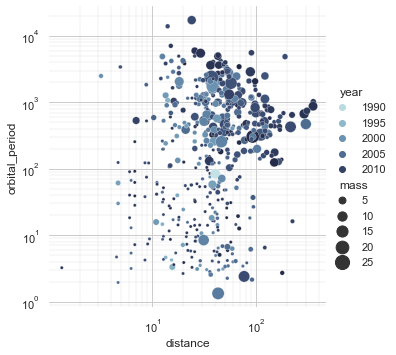

In [13]:
sns.set_theme(style="")

# Load the example planets dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=planets,
    x="distance", y="orbital_period",
    hue="year", size="mass",
    palette=cmap, sizes=(10, 200),
)
g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

In [97]:
# save your IDs from new project in Spotify Developer Dashboard
CLIENT_ID = '85f963fd683f44579fcddea6abaf1597'
CLIENT_SECRET = '098588e785aa4c4e903a981fc91f82c9'

In [98]:
# generate access token

# authentication URL
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [99]:
# used for authenticating all API calls
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}

In [100]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

In [101]:
# create blank dictionary to store track URI, artist URI, and genres
genre = {}

# convert track_uri column to an iterable list
trackUris = df_stream['uri'].dropna().to_list()

# loop through track URIs and pull artist URI using the API,
# then use artist URI to pull genres associated with that artist
# store all these in a dictionary
for trackUri in trackUris[:100]:
    genre[trackUri[14::]] = {'artist_uri': "", "genres":[]}
    
    r = requests.get(BASE_URL + 'tracks/' + trackUri[14::], headers=headers)
    r = r.json()
    artistUri = r['artists'][0]['uri'].split(':')[2]
    genre[trackUri[14::]]['artist_uri'] = artistUri
    
    s = requests.get(BASE_URL + 'artists/' + artistUri, headers=headers)
    s = s.json()
    genre[trackUri[14::]]['genres'] = s['genres']

In [102]:
# convert dictionary into dataframe with track_uri as the first column
df_genre = pd.DataFrame.from_dict(genre, orient='index')
df_genre.insert(0, 'uri', df_genre.index)
df_genre.reset_index(inplace=True, drop=True)

df_genre
df_genre_expanded = df_genre.explode('genres')
df_genre_expanded

,uri,artist_uri,genres
0,6vMpPxLV0F5Diwcs6awI1Z,360IAlyVv4PCEVjgyMZrxK,dance pop
0,6vMpPxLV0F5Diwcs6awI1Z,360IAlyVv4PCEVjgyMZrxK,pop
0,6vMpPxLV0F5Diwcs6awI1Z,360IAlyVv4PCEVjgyMZrxK,r&b
0,6vMpPxLV0F5Diwcs6awI1Z,360IAlyVv4PCEVjgyMZrxK,urban contemporary
1,3clX2NMmjaAHmBjeTSa9vV,7BMccF0hQFBpP6417k1OtQ,alternative hip hop
...,...,...,...
87,43tVqovviXhkmOV5LOkTn7,3A5tHz1SfngyOZM2gItYKu,hip hop
87,43tVqovviXhkmOV5LOkTn7,3A5tHz1SfngyOZM2gItYKu,rap
87,43tVqovviXhkmOV5LOkTn7,3A5tHz1SfngyOZM2gItYKu,underground hip hop
88,1IMgQoUuiOuieYRKYadkPr,2rwALQ1SXdfUWPUd6WOfYS,hip hop


In [103]:
df_stream.to_csv('MySpotifyDataTable.csv')
df_genre_expanded.to_csv('GenresExpandedTable.csv')